In [67]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.linear_model import LinearRegression

from utils.plot_utils import regression_plot_with_uncertainty
from utils.Prediction_bands import(split_conformal_bands,
                                   weighted_conformal_prediction
                                   
)
from concurrent.futures import ThreadPoolExecutor

from scipy.stats import multivariate_normal, norm

# SETTING 2: CHANGEPOINTS
# SETTING 3: Distribution drift
Interpolating $\beta^{(1)} = (2, 1, 0, 0)$ to $\beta^{N} = (0, 0, 2, 1)$

In [68]:
setting = 3

np.random.seed(12345)
N = 2000
alpha = 0.1
methods = ['CP+LS', 'nexCP+LS', 'nexCP+WLS', "gaussian"]
ntrial = 200
train_lag = 100

rho = rho_LS = 0.99

X = np.random.normal(size = (ntrial, N, 4))
noise = np.random.normal(size = (ntrial, N))
Y = np.zeros((ntrial, N))



if setting == 2: 
    changepoints = np.r_[500, 1500]    
    num_changepoints = 2
    beta = np.array([[2, 1, 0, 0], [0, -2, -1, 0], [0, 0, 2, 1]])
    for i in np.arange(1 + num_changepoints):
        if i == 0:
            idx_min = 0
        else:
            idx_min = changepoints[i-1]

        if (i == num_changepoints):
            idx_max = N
        else:
            idx_max = changepoints[i]
            
        Y[:, idx_min:idx_max] = X[:, idx_min:idx_max].dot(beta[i]) + noise[:, idx_min:idx_max]
        
if setting == 3:

    beta_start = np.array([2,1,0,0])
    beta_end = np.array([0,0,2,1])
    beta = beta_start + np.outer(np.arange(N)/(N-1),beta_end-beta_start)

    for i in np.arange(N):
        Y[:, i] = X[:, i].dot(beta[i]) + noise[:, i]

    


#SETTING 3: CHANGEPOINT

In [51]:
# np.random.seed(12345)
# N = 2000

# beta_start = np.array([2,1,0,0])
# beta_end = np.array([0,0,2,1])
# beta = beta_start + np.outer(np.arange(N)/(N-1),beta_end-beta_start)

# ntrial = 200
# train_lag = 100

# rho = rho_LS = 0.99

# X = np.random.normal(size = (ntrial, N, 4))
# noise = np.random.normal(size = (ntrial, N))

# Y = np.zeros((ntrial, N))

# for i in np.arange(N):
#     Y[:, i] = X[:, i].dot(beta[i]) + noise[:, i]

# alpha = 0.1
# methods = ['CP+LS', 'nexCP+LS', 'nexCP+WLS']


In [52]:
beta[1999]

array([0., 0., 2., 1.])

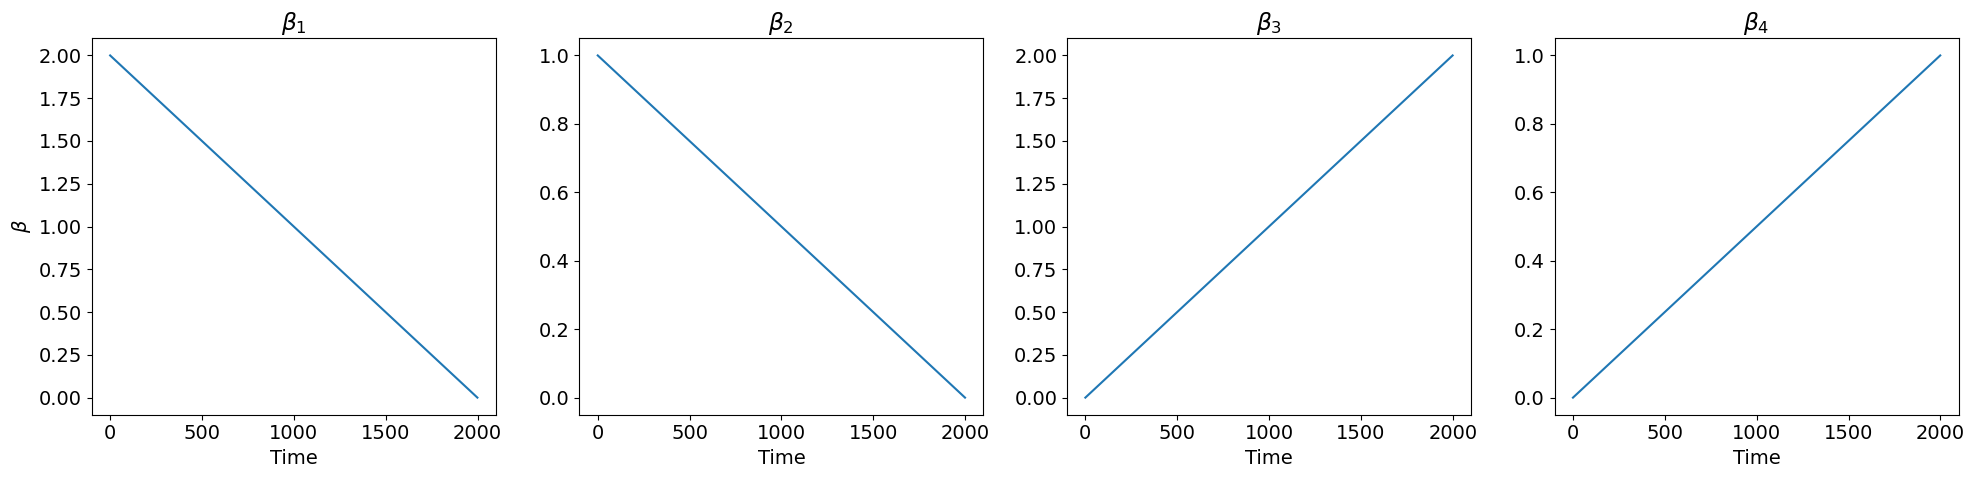

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for beta_col in range(4):
    ax[beta_col].plot(np.arange(N), beta[:, beta_col])
    ax[beta_col].set_title(r"$\beta_{}$".format(beta_col + 1))
    ax[beta_col].set_xlabel("Time")
    if beta_col == 0:
        ax[beta_col].set_ylabel(r"$\beta$") 
plt.tight_layout()
plt.show()
        

In [54]:
def run_trial(itrial):
    for pred_idx in np.arange(train_lag, N):
        # we predict the point at pred_idx (n+1) starting at pred_idx=train_lag (101-th datapoint)

        for method_idx, method in enumerate(methods):
            # calibration weights for non-exchangeable conformal prediction (nexCP)
            if method in ['nexCP+LS', 'nexCP+WLS']:
                # weights at 1, ..., n (notice: in Python arrays this becomes 0, ..., n-1)
                weights = rho**(np.arange(pred_idx,0,-1))
                # weight n+1 should always be 1
                weights = np.r_[weights,1]
        
            elif method == "gaussian":
                h = 0.84
                X_tilde = multivariate_normal.rvs(mean = X[itrial - 1, pred_idx], cov = np.diag(np.ones(4))*h**2)
                weights = np.exp(-0.5 * np.sum((X[itrial, :pred_idx] - X_tilde) , axis = 1) / h**2)
                weights = np.r_[weights, 1]
                
            else:
                weights = np.ones(pred_idx+1)
            
            # weights for weighted linear regression (WLS)
            if method == 'nexCP+WLS':
                # tags 1, ..., n+1
                tags = rho_LS**(np.arange(pred_idx,-1,-1))
                
            elif method == 'gaussian':
                tags = weights[:-1]
            else:
                tags = np.ones(pred_idx+1)
            
            

            
            # odd data points for training, even ones for calibration
            inds_odd = np.arange(1,int(np.ceil(pred_idx/2)*2-1),2) # excludes pred_idx
            inds_even = np.arange(2,int(np.floor(pred_idx/2)*2),2) # excludes pred_idx

            # train a weighted least squares regression (tags are the weights)
            predictor = LinearRegression()
            predictor.fit(X[itrial, inds_odd], Y[itrial, inds_odd], tags[inds_odd])

            mean_prediction, prediction_bands, _, _ = weighted_conformal_prediction(
                predictor, # the trained weighted linear regression model
                X[itrial, inds_even], # calibration inputs
                Y[itrial, inds_even], # calibration targets
                X[itrial, pred_idx][np.newaxis, :], # test point to predict
                weights[inds_even], # calibration score weights
                alpha # target miscoverage rate
            )
            PI_split_CP[method_idx,itrial,pred_idx,:] = prediction_bands
            
            
            if pred_idx == N - 1:
                weights_noramalised = weights / np.sum(weights)
                all_weights[method_idx, itrial, :len(weights)] = weights_noramalised

In [55]:
PI_split_CP = np.zeros((len(methods),ntrial,N,2))
PI_split_CP[:, :, :train_lag, 0] = -np.inf
PI_split_CP[:, :, :train_lag, 1] = np.inf
all_weights = np.empty((len(methods), ntrial, N), dtype=object)


with ThreadPoolExecutor(max_workers = 5) as executor:
        list(tqdm(executor.map(run_trial, np.arange(ntrial)), total=ntrial))

  0%|          | 0/200 [00:00<?, ?it/s]

[ 8.27626454  8.9975766   7.47580431 ... 22.63743559 46.67953804
  0.46840817]
[0.09275443 0.89139376 0.07447887 ... 0.09737065 0.14721411 0.02452783]
[ 7.75487938 10.79977663  5.70671871 ...  3.92137474  6.24344502
 10.156203  ]


  0%|          | 1/200 [00:20<1:07:19, 20.30s/it]

[3.73775026 0.15032842 0.62347599 ... 0.48950438 0.16202898 2.10249015]
[0.41607615 0.1061812  0.25521635 ... 0.30248098 0.31771826 0.55683141]


  4%|▎         | 7/200 [00:40<15:44,  4.89s/it]  

[ 6.0898785   4.9349904   4.942032   ... 49.01213873  0.86579528
  2.42930072]
[ 2.73865064 15.62060781 19.25783602 ... 73.40698188 10.81839228
  4.05742489]


  4%|▍         | 8/200 [00:41<12:44,  3.98s/it]

[0.01760736 0.24916653 0.04231674 ... 0.61586302 0.16263598 0.66947721]
[ 49.70362186  28.98844272  45.06302093 ...  19.429795    80.93979062
 143.49650454]


  4%|▍         | 9/200 [00:42<10:01,  3.15s/it]

[57.19721692 32.59807227 51.48969019 ...  8.77265651 55.11840846
 60.28707028]


  6%|▌         | 11/200 [01:02<19:09,  6.08s/it]

[ 3.05420918  5.31371733  6.89418602 ... 19.48655593  0.46755478
  0.38090259]


  6%|▌         | 12/200 [01:03<15:20,  4.90s/it]

[22.2548011   5.06438956  0.41067699 ...  1.36332477 11.81150279
  3.7792014 ]
[0.10310414 0.08730764 0.43813503 ... 1.41304217 0.09404081 0.86098224]
[6.06201181 0.78233386 0.01229681 ... 0.35164487 0.3727959  0.04829271]


  8%|▊         | 15/200 [01:04<07:55,  2.57s/it]

[0.04551955 0.79189295 1.59691867 ... 0.05817532 0.33367372 0.23674934]


  8%|▊         | 16/200 [01:26<19:23,  6.32s/it]

[0.13358972 1.7861961  8.76152217 ... 0.71340843 4.59372803 0.61606219]


  8%|▊         | 17/200 [01:27<15:46,  5.17s/it]

[127.08374813   0.37615904   0.9751738  ...  10.06239549  14.99584909
   3.03897856]


  9%|▉         | 18/200 [01:27<12:10,  4.02s/it]

[12.57139852  8.35622614  2.09711689 ...  0.31667345  2.10315929
 14.44852803]


 10%|▉         | 19/200 [01:28<09:39,  3.20s/it]

[0.29681094 1.13845084 0.17917996 ... 0.00888472 0.1741557  1.13772679]
[29.72270749  0.48211859  1.28911777 ...  4.32648532  1.38392569
  2.76623813]


 10%|█         | 21/200 [01:52<20:40,  6.93s/it]

[1.52345087 0.2799268  0.22193506 ... 0.36427795 0.17088641 1.25988043]


 11%|█         | 22/200 [01:53<16:22,  5.52s/it]

[ 22.64459689  60.09916778  53.52637606 ... 107.92730551  50.99913086
  20.6621717 ]
[0.43142546 2.48955284 0.12142463 ... 0.05870688 0.09455054 3.26782457]


 12%|█▏        | 23/200 [01:53<12:31,  4.25s/it]

[ 2.48464409 10.42138241  5.72828799 ...  6.74079641  0.12734431
  0.80904159]


 12%|█▏        | 24/200 [01:54<09:34,  3.26s/it]

[14.48427458  1.02604987  7.45422975 ...  6.48583998 10.18765108
 27.7528225 ]


 13%|█▎        | 26/200 [02:17<19:28,  6.72s/it]

[0.00621866 0.04156406 0.01172858 ... 0.0106764  0.25603669 0.03918755]


 14%|█▎        | 27/200 [02:17<15:14,  5.29s/it]

[3.19582292 4.22809402 0.65751364 ... 1.53147622 0.29810109 1.07255727]
[  30.35607791   32.37155529  114.20523993 ...  734.15072658  180.21364483
 1020.57975473]
[ 0.31117747 17.06667534  2.9301637  ...  0.25305321  0.07034163
  1.05338866]


 15%|█▌        | 30/200 [02:18<07:59,  2.82s/it]

[1.33637821 0.26371823 9.23533267 ... 0.80531727 0.43078878 0.9603953 ]


 16%|█▌        | 31/200 [02:41<18:46,  6.66s/it]

[0.02198915 0.0086076  0.28139718 ... 0.00056945 0.00264608 0.06695897]
[ 2.13942754  0.45060132  1.12192929 ... 13.71761478  1.06573542
  0.73128006]
[ 4.87848675 32.92942032 24.41044026 ...  6.30361121  0.79525298
  1.34164   ]
[0.14739815 0.25655773 0.01804386 ... 0.10648546 0.00673628 0.01226587]
[1.06081119 0.16284213 0.87407992 ... 0.13413391 0.63285254 0.31459686]


 18%|█▊        | 36/200 [03:05<15:08,  5.54s/it]

[76.56415609  8.81190541  4.87382164 ... 41.3284249   4.96865135
  1.92018238]
[0.00154092 0.08175345 0.0529379  ... 0.03649871 0.13284594 0.01669779]


 19%|█▉        | 38/200 [03:05<10:59,  4.07s/it]

[3.1789737  9.54243447 7.72456175 ... 0.41020177 3.97360937 8.71326121]


 20%|█▉        | 39/200 [03:06<09:22,  3.50s/it]

[  0.27511933   1.39232344   0.99402965 ...  15.20381044 151.44683327
   4.77931253]


 20%|██        | 40/200 [03:06<07:39,  2.87s/it]

[0.73827018 0.97456707 0.2008992  ... 5.68239297 1.53100762 2.34710425]


 20%|██        | 41/200 [03:29<18:58,  7.16s/it]

[193.24368993  11.04848775   7.67504901 ...  28.289806    41.45391099
 158.46040672]
[ 1.93731083  1.37951031  2.7775915  ...  1.63049607 11.1110588
  0.98488577]
[11.66202558  1.53378033  0.34878424 ...  0.72311959  3.94765951
  0.13641091]
[7.58928369 0.64477673 3.26146419 ... 8.84212792 7.63009069 7.92618551]


 22%|██▏       | 44/200 [03:31<10:20,  3.98s/it]

[1.13071231 1.60063694 1.29151782 ... 2.1705005  0.24287401 0.97193236]


 23%|██▎       | 46/200 [03:56<17:13,  6.71s/it]

[0.03149714 0.03160958 0.2899417  ... 0.23395222 0.32150555 0.01535155]


 24%|██▎       | 47/200 [03:56<14:07,  5.54s/it]

[0.2527645  0.24945928 0.31258599 ... 0.13930051 0.20274908 1.1001687 ]
[0.00761348 0.04525393 0.02250708 ... 0.38498727 0.00102071 0.04042294]


 24%|██▍       | 49/200 [03:57<09:17,  3.69s/it]

[0.03032466 0.1462906  0.07312112 ... 0.51606614 0.30168543 1.03250369]


 25%|██▌       | 50/200 [03:58<08:07,  3.25s/it]

[ 6.47590393  1.08508594 15.83733887 ...  0.67942587  0.45925853
  6.61147011]
[0.50547621 0.03292365 1.42278653 ... 0.06958004 0.30755985 0.50612966]
[0.53834719 0.54975173 0.99667591 ... 0.72413795 0.85178397 0.31862848]


 26%|██▌       | 51/200 [04:24<20:36,  8.30s/it]

[2.09243104 0.87445164 1.26891781 ... 4.48874038 0.06757433 0.98266926]
[0.11365118 0.22172591 0.31263644 ... 0.06126453 0.13870928 0.02776206]


 28%|██▊       | 55/200 [04:26<09:25,  3.90s/it]

[0.75662062 0.06982714 0.31306286 ... 0.4123237  7.65118649 0.39480389]
[0.11960179 7.24961977 2.61759819 ... 3.0314301  0.52357244 8.75151557]
[0.01805314 0.17822906 0.14465587 ... 0.61613323 0.15643562 0.06018916]
[0.2646961  0.27121998 0.25109301 ... 1.86027645 0.36002599 4.24485056]


 28%|██▊       | 56/200 [04:52<18:12,  7.59s/it]

[  15.5619311   148.46924853  208.05002853 ...    5.0628227    47.34798138
 1466.38650076]


 30%|███       | 60/200 [04:53<09:16,  3.97s/it]

[3.23037397 8.77542231 3.79975747 ... 0.66993053 8.5644992  0.17423368]


 30%|███       | 61/200 [05:19<16:51,  7.27s/it]

[0.19428243 0.32294106 0.39172175 ... 0.62910467 0.23046054 0.16274575]
[0.47142488 0.15301295 0.34549626 ... 2.43752976 0.12905452 0.77710564]
[ 2.5431612  21.15460538  3.69037245 ... 14.87767581  1.52298861
 31.00317896]


 31%|███       | 62/200 [05:21<14:33,  6.33s/it]

[0.13104236 0.14402165 0.22555069 ... 0.06956319 0.38600167 0.45630958]


 32%|███▎      | 65/200 [05:21<08:19,  3.70s/it]

[0.15374222 0.35281258 0.02508444 ... 0.95302875 0.19086391 0.01184913]


 33%|███▎      | 66/200 [05:47<16:33,  7.41s/it]

[0.6922743  0.32886597 0.56600628 ... 1.2434455  3.90526195 0.25732305]


 34%|███▎      | 67/200 [05:48<13:45,  6.21s/it]

[ 0.44033723 12.20319332  3.41229221 ...  0.13027069  0.29819905
  0.31631725]
[ 14.27322529 156.11232265  25.67297033 ...  35.45565764  16.75118987
  88.18341145]
[12.95320191 20.85534449 37.32501676 ...  2.27889763 92.02004653
 11.48427032]


 34%|███▍      | 68/200 [05:49<11:04,  5.03s/it]

[17.77329299 29.0251288  13.71371903 ...  4.20691609  0.48929808
 14.76444328]


 36%|███▌      | 71/200 [06:12<13:35,  6.32s/it]

[ 1.29424463  2.57495841 11.84236571 ...  2.16712848  1.46839875
  0.22537112]


 36%|███▌      | 72/200 [06:14<11:33,  5.42s/it]

[ 34.41709381  19.88021843   0.82417286 ...  15.13235308   8.46521355
 159.84347235]
[1.83581941 0.12165609 3.75653754 ... 0.95541687 8.44372945 0.2245271 ]
[0.15966159 0.08125128 0.06868527 ... 0.13496236 0.12735473 0.01469036]


 36%|███▋      | 73/200 [06:14<09:23,  4.44s/it]

[1.54865195 0.38632691 0.62672102 ... 0.8897662  0.60330804 0.1549443 ]


 38%|███▊      | 76/200 [06:37<12:22,  5.99s/it]

[0.54682606 0.88919442 0.02133177 ... 0.08945884 2.64112422 0.28496672]


 38%|███▊      | 77/200 [06:39<10:30,  5.13s/it]

[0.15981813 1.0207107  4.34818905 ... 0.28298407 0.28157125 3.51083418]


 39%|███▉      | 78/200 [06:39<08:24,  4.14s/it]

[ 319.81294076   61.5475555   163.97311878 ...   62.04269073 1842.75974707
  117.25083819]
[1.96859181 3.46194221 0.09753033 ... 0.70500262 0.45179926 0.48408153]


 40%|████      | 80/200 [06:40<05:21,  2.68s/it]

[ 18.25910114   1.31557325   1.82019135 ... 148.46139459   7.83008576
   1.46251296]


 40%|████      | 81/200 [07:02<13:42,  6.91s/it]

[ 0.37860456 24.23506449  1.9388039  ...  4.6623828  11.05905672
  0.90901833]


 41%|████      | 82/200 [07:04<11:15,  5.73s/it]

[0.81432378 0.10124631 0.30482873 ... 0.26626579 6.16141298 2.4362177 ]
[0.037046   2.59917145 0.04580636 ... 0.75273273 0.06946816 1.06586872]


 42%|████▏     | 84/200 [07:04<06:43,  3.48s/it]

[ 1.3410148  26.07674065 27.1090433  ... 24.36889118  1.42576126
 44.06691176]


 42%|████▎     | 85/200 [07:05<05:38,  2.94s/it]

[76.36391083 39.66590622 31.46279523 ...  2.39591347 21.75806926
 22.44946619]


 43%|████▎     | 86/200 [07:28<14:30,  7.63s/it]

[149.22382934  36.73521872   1.17570006 ...   3.74551654   3.69588687
   0.26598993]
[0.03476756 0.5342834  0.01234782 ... 0.36651023 0.05377475 0.04442296]


 44%|████▍     | 88/200 [07:30<08:28,  4.54s/it]

[ 0.10180958  7.76838287  7.75039167 ... 28.48855602  0.19235284
  5.55417151]
[ 2.61247616  3.60447534 14.73908537 ...  1.14301403  0.6585153
  0.30619666]


 45%|████▌     | 90/200 [07:31<05:03,  2.76s/it]

[15.6851803   5.48211747  1.53679827 ...  1.16157206  3.11071658
  9.97610933]


 46%|████▌     | 91/200 [07:53<13:36,  7.49s/it]

[0.24209985 0.45011984 0.07524092 ... 0.54336305 0.48624641 0.02269743]


 46%|████▌     | 92/200 [07:55<10:51,  6.03s/it]

[5.93429209 2.28883898 0.06244858 ... 0.26771715 0.49286349 9.20032172]
[137.20904602   0.43341027   4.81689956 ...   2.85730026   3.2271057
   0.32978026]
[ 2.23148751  0.48555056  3.38664339 ... 18.69050254 12.6189853
  0.79495462]


 48%|████▊     | 95/200 [07:57<05:37,  3.22s/it]

[4.06055347 0.31816315 1.17281589 ... 1.78163958 2.45172794 0.64181829]


 48%|████▊     | 96/200 [08:19<12:11,  7.03s/it]

[0.38650392 0.44255614 0.1315147  ... 0.09042274 0.18593441 0.30803565]
[3.79087838 0.14592755 2.98760401 ... 0.05157494 1.6611095  0.61162798]


 48%|████▊     | 97/200 [08:21<10:05,  5.88s/it]

[2.31030592 0.62596845 1.84993989 ... 1.90275804 1.30554599 0.2579532 ]
[1.75105577 0.83634739 1.20247701 ... 0.35497046 1.14178306 0.60052743]


 50%|█████     | 100/200 [08:23<05:32,  3.33s/it]

[0.06952952 0.03442609 0.21174002 ... 0.0232733  0.09668516 0.0238322 ]


 50%|█████     | 101/200 [08:45<11:15,  6.83s/it]

[ 0.24922502  0.61217444 13.63555818 ...  1.21187731  0.4401542
  3.89681924]


 51%|█████     | 102/200 [08:47<09:22,  5.74s/it]

[ 0.65692913 39.86360938  0.64286033 ...  0.52018644 26.00072534
  4.26473655]


 52%|█████▏    | 103/200 [08:47<07:18,  4.52s/it]

[ 0.77545809  2.75928047  2.73545347 ...  1.53823118  3.50021343
 13.98299307]
[  8.70319716 503.91903192  61.21852714 ...   6.49604391   7.17362091
  14.9783224 ]


 52%|█████▎    | 105/200 [08:49<04:46,  3.01s/it]

[1.6806348  2.4702381  2.73108476 ... 2.20678177 0.36618081 8.76051388]


 53%|█████▎    | 106/200 [09:11<11:29,  7.33s/it]

[0.01845227 0.05595582 0.11653891 ... 0.10136923 0.1658955  0.11806801]


 54%|█████▎    | 107/200 [09:13<09:14,  5.96s/it]

[ 12.81435623   8.95491994   8.36826363 ... 111.92897713   2.26813754
   8.33391768]


 54%|█████▍    | 108/200 [09:13<06:59,  4.56s/it]

[0.53825577 2.23533408 1.24179673 ... 1.56496387 3.6708268  0.56068399]
[0.18733497 0.30221666 0.56319382 ... 0.14738721 0.24498293 0.40398468]


 55%|█████▌    | 110/200 [09:15<04:18,  2.87s/it]

[0.13802599 0.02467218 0.03715319 ... 0.14921158 0.11472694 0.204601  ]


 56%|█████▌    | 111/200 [09:37<10:55,  7.37s/it]

[5.63942029 0.30442693 4.94001571 ... 0.27116781 0.19327335 3.51929749]


 56%|█████▌    | 112/200 [09:38<08:42,  5.94s/it]

[0.91667278 1.44156833 1.65338736 ... 2.10896087 1.29152628 1.06123063]
[15.33175742  0.91925592 40.25933782 ... 11.36881791  6.68663549
  2.07205097]


 57%|█████▋    | 114/200 [09:39<05:04,  3.54s/it]

[3.32157663 0.79370803 4.79205466 ... 0.7637517  8.70482569 1.09970057]


 57%|█████▊    | 115/200 [09:40<04:17,  3.03s/it]

[0.68639249 0.34666135 0.12983532 ... 0.55354923 0.38998655 0.21262124]


 58%|█████▊    | 116/200 [10:02<10:47,  7.71s/it]

[4.14188562 0.10359868 0.21403607 ... 0.29370611 0.15783896 1.0213382 ]
[ 2.4217795   2.00028243  1.73632734 ...  7.77884999  3.95562659
 31.4201164 ]


 58%|█████▊    | 117/200 [10:04<08:43,  6.31s/it]

[0.33203972 1.25239034 1.31848613 ... 2.62042428 0.79133489 8.02833096]
[0.36780439 7.80790589 5.32446042 ... 7.51637594 5.48381722 2.29826872]


 60%|██████    | 120/200 [10:06<04:18,  3.23s/it]

[0.24214766 0.48914741 0.14753757 ... 0.05136508 0.0791402  1.30998035]


 60%|██████    | 121/200 [10:33<10:40,  8.11s/it]

[0.45244888 0.01388925 0.19749324 ... 0.09113442 0.02853796 0.06776829]


 61%|██████    | 122/200 [10:35<08:47,  6.76s/it]

[ 7.8343578   9.59780955 33.01008477 ... 91.30233898 33.64730204
 22.44498736]
[ 1.80329177 14.30703061  1.58074441 ...  9.09634884  5.78336637
 15.03662774]


 62%|██████▏   | 123/200 [10:36<06:49,  5.31s/it]

[0.02058991 0.2112376  0.05791694 ... 0.31149284 0.14460955 0.09970351]


 62%|██████▎   | 125/200 [10:38<04:21,  3.48s/it]

[0.33969293 0.18978698 0.33955144 ... 1.14914145 2.85041446 3.23502582]


 63%|██████▎   | 126/200 [11:00<09:31,  7.72s/it]

[ 6.16807904 18.59629993  1.86650751 ... 87.64198582  3.71614715
 16.34867108]


 64%|██████▎   | 127/200 [11:02<07:43,  6.35s/it]

[0.11606651 1.22174645 0.23835339 ... 0.18021363 1.08463292 0.88578052]


 64%|██████▍   | 129/200 [11:03<04:11,  3.55s/it]

[ 4.76897752 20.10749338 60.06259377 ... 15.9710579  12.69558473
 22.79222019]
[ 0.19147741 15.85612003 27.31733358 ...  1.03681903 14.00014866
 17.85786989]


 65%|██████▌   | 130/200 [11:04<03:30,  3.01s/it]

[  6.90999344 220.03595532   2.46614038 ...   8.40278026  25.01219168
  13.60287933]


 66%|██████▌   | 131/200 [11:26<09:27,  8.23s/it]

[122.74147973  80.66238883 113.22419524 ... 509.7833509   47.5365362
  99.71179321]


 66%|██████▌   | 132/200 [11:28<07:18,  6.46s/it]

[9.44807034 3.12014007 0.84508418 ... 7.34383238 0.06907482 0.07249061]


 66%|██████▋   | 133/200 [11:28<05:12,  4.67s/it]

[0.25548886 0.23710146 0.39250706 ... 4.59620989 0.48808799 0.63930936]


 67%|██████▋   | 134/200 [11:29<03:46,  3.43s/it]

[0.03799146 0.00651066 0.02748679 ... 0.00976147 0.02148278 0.01780933]


 68%|██████▊   | 135/200 [11:31<03:16,  3.02s/it]

[2.29763503 1.71353976 7.02077397 ... 0.36433586 0.46253357 5.56819842]


 68%|██████▊   | 136/200 [11:52<08:58,  8.42s/it]

[ 0.17892942  0.81516731  1.57877399 ...  0.04828166  3.66415273
 10.37155184]
[0.03179506 0.02478749 0.10633236 ... 0.04208203 0.11633333 0.5378141 ]


 68%|██████▊   | 137/200 [11:54<06:52,  6.55s/it]

[0.43713358 0.08317404 0.08736114 ... 0.04567938 0.18697236 0.08289829]


 70%|██████▉   | 139/200 [11:55<03:51,  3.79s/it]

[7.2153257  8.52349139 9.3326651  ... 3.97328317 3.14426461 1.02976538]


 70%|███████   | 140/200 [11:56<03:12,  3.20s/it]

[20.88701649  4.84995593  1.24607979 ...  3.42421459  0.94428751
  4.17928023]


 70%|███████   | 141/200 [12:18<07:44,  7.88s/it]

[0.49675067 0.86374086 0.0810171  ... 3.93514555 0.6095048  0.17264827]


 71%|███████   | 142/200 [12:20<06:03,  6.26s/it]

[2.78705104 1.4106535  1.2903695  ... 0.71873893 4.6455259  0.31983739]


 72%|███████▏  | 143/200 [12:20<04:24,  4.64s/it]

[ 4.53319923  0.33954932 12.04456357 ... 13.73225675  0.38983408
  1.32107983]


 72%|███████▏  | 144/200 [12:21<03:18,  3.55s/it]

[0.14088115 1.33268014 0.38904839 ... 0.18044081 0.32002337 1.21854159]


 72%|███████▎  | 145/200 [12:23<02:49,  3.08s/it]

[ 0.26147693  0.75222496  0.71565754 ... 11.49982829  1.56892535
  9.7921936 ]


 73%|███████▎  | 146/200 [12:44<07:33,  8.40s/it]

[0.14441394 0.07861327 0.0453754  ... 0.16818627 0.14455826 0.27893495]


 74%|███████▎  | 147/200 [12:46<05:41,  6.44s/it]

[0.10700122 0.18288354 0.11067309 ... 0.12187289 0.10409067 0.21925091]


 74%|███████▍  | 148/200 [12:46<04:01,  4.64s/it]

[ 5.65804536  2.09635222  2.81582722 ...  0.9476942   0.7006644
 23.17077314]


 74%|███████▍  | 149/200 [12:47<03:00,  3.54s/it]

[0.0625546  0.09971077 0.17974043 ... 4.44280833 0.08187472 0.89637689]


 75%|███████▌  | 150/200 [12:49<02:32,  3.05s/it]

[0.12841378 0.63873794 1.09552847 ... 0.17481703 1.28460494 0.47339215]


 76%|███████▌  | 151/200 [13:10<06:46,  8.30s/it]

[ 0.1312637  13.7706458  10.30147002 ...  5.91509962  1.23751906
  1.83498518]


 76%|███████▋  | 153/200 [13:12<03:32,  4.53s/it]

[ 6.82112771  6.87015808  3.99893999 ...  3.59113052 60.48932243
  3.89842694]
[ 0.5617448   2.46108495  0.01706458 ...  0.11968444  0.21892624
 12.11091045]


 77%|███████▋  | 154/200 [13:13<02:40,  3.48s/it]

[0.29498971 0.02389342 0.47103362 ... 1.95611034 0.5569979  0.33660755]


 78%|███████▊  | 155/200 [13:15<02:19,  3.10s/it]

[7.02694988 0.56171144 2.01076076 ... 7.22902974 4.06420526 0.98520703]


 78%|███████▊  | 156/200 [13:36<06:09,  8.40s/it]

[159.37571178  11.46997587   3.47278319 ... 112.3953798  187.53813991
   3.41184925]


 78%|███████▊  | 157/200 [13:37<04:35,  6.41s/it]

[ 15.4260533    9.32011172  56.41027057 ...   7.23333316 191.95568192
 585.33195899]


 79%|███████▉  | 158/200 [13:38<03:12,  4.59s/it]

[0.16256045 0.22457874 0.04960111 ... 9.52953662 4.27990078 0.23919371]


 80%|███████▉  | 159/200 [13:39<02:24,  3.52s/it]

[0.6617886  0.48159526 1.14440672 ... 2.67542614 0.83288256 0.39779901]


 80%|████████  | 160/200 [13:41<02:06,  3.17s/it]

[1.11266587 0.13139882 1.83431409 ... 3.11541769 7.28286108 2.10306513]


 80%|████████  | 161/200 [14:01<05:21,  8.25s/it]

[ 0.84500178 10.2539431   2.88842557 ... 35.27078609  9.70269999
  7.67598473]


 81%|████████  | 162/200 [14:03<03:57,  6.26s/it]

[0.00352781 0.23157254 0.07626514 ... 0.00078672 0.0062677  0.00439895]


 82%|████████▏ | 163/200 [14:04<02:50,  4.60s/it]

[20.08708734 82.61007213 19.84891277 ...  3.52167454  2.79186414
  7.10050752]


 82%|████████▏ | 164/200 [14:05<02:07,  3.53s/it]

[9.39158164 2.0136051  0.40810047 ... 1.34263005 1.33898986 0.99960807]


 82%|████████▎ | 165/200 [14:07<01:55,  3.30s/it]

[1.35048633 1.11156758 1.59372989 ... 2.21325273 0.75697126 0.9521903 ]


 83%|████████▎ | 166/200 [14:29<04:54,  8.66s/it]

[1.02608201 0.30724249 5.38571011 ... 0.23042896 0.07680905 0.08663474]


 84%|████████▎ | 167/200 [14:30<03:35,  6.53s/it]

[3.38153863 0.09195403 0.47335717 ... 1.604869   1.90348855 7.4560165 ]


 84%|████████▍ | 168/200 [14:31<02:33,  4.81s/it]

[589.56317994 222.14867211  20.22128299 ...  50.84288351  10.58230614
  19.84045025]


 84%|████████▍ | 169/200 [14:33<01:59,  3.85s/it]

[8.90857429 0.94755663 4.71997128 ... 0.78501658 0.77280481 3.06593725]


 85%|████████▌ | 170/200 [14:35<01:40,  3.35s/it]

[ 36.78827757  69.57087095  73.23621307 ...  15.89495436 180.65068054
  29.43393061]


 86%|████████▌ | 171/200 [14:54<03:59,  8.26s/it]

[0.86335502 0.64432857 4.95943066 ... 9.70309064 1.39265901 2.72717468]


 86%|████████▌ | 172/200 [14:56<02:56,  6.32s/it]

[20.42845108  5.09105284  4.39534261 ... 13.59998688  7.82407141
 11.74064712]


 86%|████████▋ | 173/200 [14:57<02:05,  4.66s/it]

[124.25589908  11.91179957 150.9575213  ...  29.07680453  38.09096029
   4.7395158 ]


 87%|████████▋ | 174/200 [14:58<01:34,  3.64s/it]

[2.26422607 2.38220369 2.05129104 ... 0.1925249  0.74156281 0.58828232]


 88%|████████▊ | 175/200 [15:01<01:21,  3.25s/it]

[0.13286067 6.83090232 0.4197328  ... 0.11556611 0.26921892 0.48804792]


 88%|████████▊ | 176/200 [15:21<03:21,  8.40s/it]

[0.08683972 0.10809755 0.00680246 ... 0.03704745 0.00853496 0.00478721]


 88%|████████▊ | 177/200 [15:23<02:29,  6.49s/it]

[0.32933994 0.37953929 0.05569872 ... 0.21286046 0.27621277 0.22983277]


 89%|████████▉ | 178/200 [15:24<01:43,  4.72s/it]

[ 2.02069717 12.56419289  1.88196661 ...  9.6119981  28.72842405
  3.2377879 ]


 90%|████████▉ | 179/200 [15:25<01:18,  3.74s/it]

[0.4137195  0.05931676 0.0194428  ... 0.123827   0.03106496 0.01337941]


 90%|█████████ | 180/200 [15:28<01:07,  3.36s/it]

[0.0989366  0.40580751 0.94944988 ... 0.82231106 0.08126943 0.09068331]


 90%|█████████ | 181/200 [15:50<02:52,  9.10s/it]

[ 1.31707717  5.48211271  2.70198806 ...  1.20501992  3.68023346
 34.55188389]


 91%|█████████ | 182/200 [15:53<02:09,  7.19s/it]

[14.29478796  5.09999502  4.05986645 ...  2.76773559 32.62218104
  7.06499589]


 92%|█████████▏| 183/200 [15:54<01:30,  5.31s/it]

[0.20185537 0.91204139 0.07505674 ... 2.2854266  0.12046868 0.2058191 ]


 92%|█████████▏| 184/200 [15:55<01:07,  4.21s/it]

[0.01033792 0.05975659 0.0368226  ... 0.02361    0.01572609 0.10447036]


 92%|█████████▎| 185/200 [16:00<01:04,  4.28s/it]

[  3.53309477  30.76482011  13.74293556 ... 142.05562056   4.70834867
   3.51594511]


 93%|█████████▎| 186/200 [16:18<01:59,  8.53s/it]

[0.24909989 0.52826986 0.1257469  ... 0.77517216 0.07291571 0.08013467]


 94%|█████████▎| 187/200 [16:21<01:27,  6.70s/it]

[  4.47714988   6.08092384  64.97519609 ... 148.18401378  15.33579902
  22.23136159]


 94%|█████████▍| 188/200 [16:21<00:58,  4.86s/it]

[0.04352985 0.11997779 0.38908886 ... 2.09647467 0.1789667  0.13963882]


 94%|█████████▍| 189/200 [16:23<00:42,  3.88s/it]

[418.61025218  12.24896422  15.53237885 ...  92.75821541  65.8592515
   5.98835267]


 95%|█████████▌| 190/200 [16:26<00:36,  3.62s/it]

[ 1.74568777  3.24231326  6.96205752 ... 23.7082928   1.91096626
  5.53799555]


 96%|█████████▌| 191/200 [16:41<01:04,  7.12s/it]

[ 2.08293807  6.33514858  7.38181093 ...  3.77417907  7.32032988
 20.17371634]


 96%|█████████▌| 192/200 [16:43<00:44,  5.52s/it]

[0.04533188 0.08783984 0.19353814 ... 0.6495954  0.28614173 0.94114628]


 96%|█████████▋| 193/200 [16:44<00:28,  4.06s/it]

[ 64.6780117  120.42101282   0.87344491 ...   4.56277993   4.26716713
  75.13294226]


 97%|█████████▋| 194/200 [16:44<00:18,  3.08s/it]

[ 0.18171037 29.23419682  3.08899892 ...  0.68859601  0.74516662
  1.83143245]


 98%|█████████▊| 195/200 [16:48<00:15,  3.17s/it]

[0.05481923 0.00299548 0.01224786 ... 0.0607543  0.01621452 1.51515203]


 98%|█████████▊| 196/200 [17:03<00:27,  6.86s/it]

[0.4518714  0.12920319 0.08009498 ... 0.77158105 0.08310906 0.06311574]


100%|█████████▉| 199/200 [17:05<00:02,  2.82s/it]

[0.02858102 1.12097437 3.95671723 ... 7.8922255  1.4945948  5.04796696]
[ 99.7780928   65.46122636  15.12325447 ... 153.59143722  28.95941005
  13.20355346]
[0.04174982 0.80731029 0.45026129 ... 1.06091932 0.21196506 4.36013167]


100%|██████████| 200/200 [17:05<00:00,  5.13s/it]

[157.2166309   29.42220676   8.67605687 ...  47.99794011   5.37401337
   6.89806379]


In [56]:
all_weights.shape

(4, 200, 2000)

In [57]:
coverage = np.zeros((len(methods),N - train_lag))
pi_width = np.zeros((len(methods),N - train_lag))


for method_idx, method in enumerate(methods):   
    lower_bound = PI_split_CP[method_idx, :, train_lag:, 0]
    upper_bound = PI_split_CP[method_idx, :, train_lag:, 1]
    
    coverage[method_idx] = np.mean((lower_bound <= Y[:, train_lag:]) & (upper_bound >= Y[:, train_lag:]), axis=0)
    pi_width[method_idx] = np.mean(upper_bound - lower_bound, axis=0)


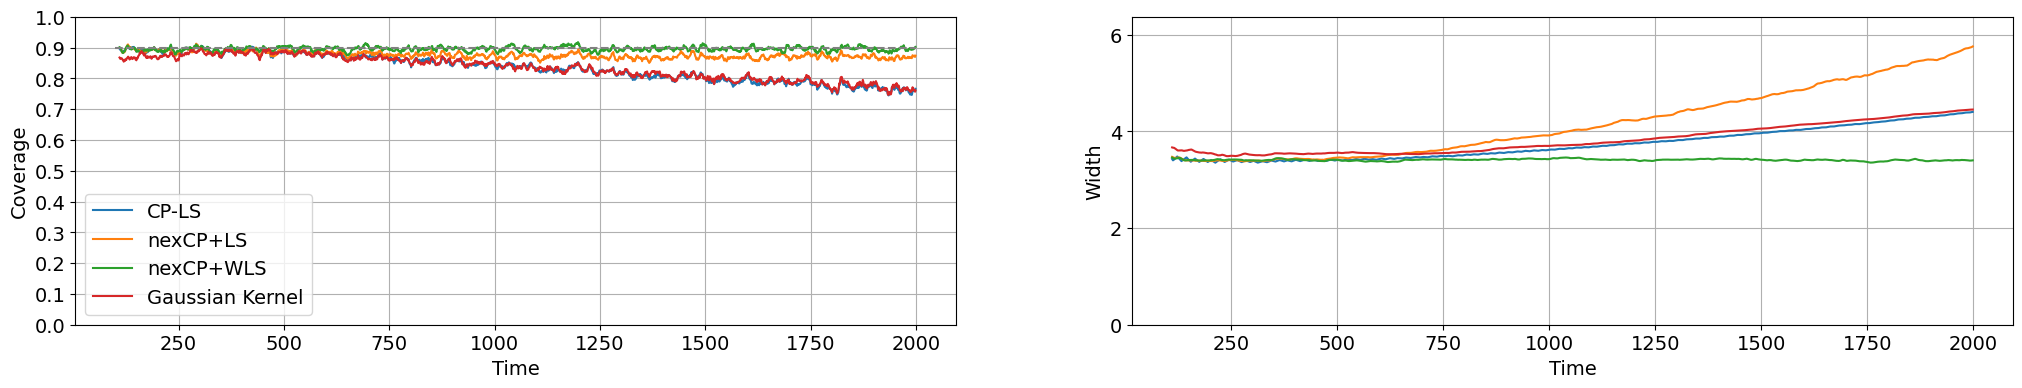

In [58]:
plt.rcParams.update({'font.size': 14})

window = 10 # will display a rolling average

def rolling_avg(x,window):
    return np.convolve(x, np.ones(window)/window)[(window-1):-window]
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,4))

for method_idx, method in enumerate(methods):
    ax[0].plot(np.arange(train_lag+window,N), rolling_avg(coverage[method_idx], window))
    ax[1].plot(np.arange(train_lag + window, N), rolling_avg(pi_width[method_idx], window))

ax[0].hlines(1-alpha, xmin=train_lag, xmax=N, linestyles='--', colors='gray')
ax[0].legend(['CP-LS','nexCP+LS','nexCP+WLS', "Gaussian Kernel"])

ax[0].set_ylabel('Coverage')
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax[0].set_xlabel('Time')
ax[0].grid(True)

ax[1].set_ylabel('Width')
ymax = np.max([
    pi_width[method_idx].max() for method_idx in range(len(methods))
]) * 1.1
ax[1].set_ylim([0, ymax])
ax[1].set_yticks([0, 2, 4, 6])
ax[1].set_xlabel('Time')
ax[1].grid(True)


plt.show()

In [59]:
for method_idx, method in enumerate(methods):
    print(f'{method}')
    print('-'*30)
    print(f'Avg. coverage: {np.mean(coverage[method_idx]):.3f}')
    print(f'Avg. interval width: {np.mean(pi_width[method_idx]):.2f}')
    print()

CP+LS
------------------------------
Avg. coverage: 0.836
Avg. interval width: 3.73

nexCP+LS
------------------------------
Avg. coverage: 0.876
Avg. interval width: 4.19

nexCP+WLS
------------------------------
Avg. coverage: 0.896
Avg. interval width: 3.41

gaussian
------------------------------
Avg. coverage: 0.835
Avg. interval width: 3.83



In [60]:
import pandas as pd
data = {'Method': methods,
    'Avg. Coverage': [np.mean(coverage[method_idx]) for method_idx in range(len(methods))],
    'Avg. Interval Width': [np.mean(pi_width[method_idx]) for method_idx in range(len(methods))]}
df = pd.DataFrame(data)

df.head()


,Method,Avg. Coverage,Avg. Interval Width
0,CP+LS,0.835579,3.730184
1,nexCP+LS,0.876224,4.185311
2,nexCP+WLS,0.895511,3.408020
3,gaussian,0.834721,3.825576


In [61]:
import pyperclip
latex_table = df.to_latex(index=False, float_format="%.3f", column_format="lcc")
pyperclip.copy(latex_table)
print("LaTeX table copied to clipboard.")


LaTeX table copied to clipboard.


In [62]:
all_weights.shape

(4, 200, 2000)

In [63]:
average_weights = np.mean(all_weights, axis=1)
average_weights.shape

(4, 2000)

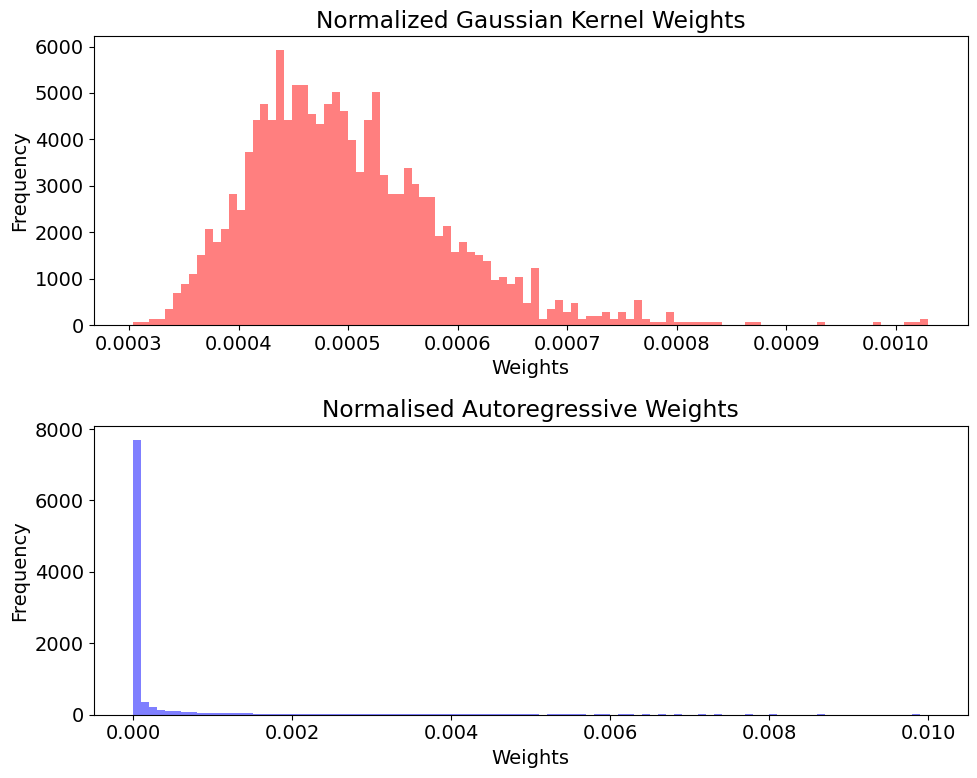

In [64]:
gaussian_weights = average_weights[3, :]
autoregressive_weights = average_weights[2, :]

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].hist(gaussian_weights, bins=100, color='red', alpha=0.5, density=True)
ax[0].set_xlabel("Weights")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Normalized Gaussian Kernel Weights")

ax[1].hist(autoregressive_weights, bins=100, color='blue', alpha=0.5, density=True)
ax[1].set_xlabel("Weights")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Normalised Autoregressive Weights")

plt.tight_layout()
plt.show()


In [65]:
max(gaussian_weights)

0.0010298307056489015

(array([1.541e+03, 6.900e+01, 4.100e+01, 2.800e+01, 2.200e+01, 1.900e+01,
        1.500e+01, 1.300e+01, 1.200e+01, 1.000e+01, 1.000e+01, 9.000e+00,
        7.000e+00, 8.000e+00, 7.000e+00, 6.000e+00, 6.000e+00, 6.000e+00,
        5.000e+00, 5.000e+00, 5.000e+00, 5.000e+00, 4.000e+00, 5.000e+00,
        4.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 4.000e+00,
        3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        3.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 2.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 2.000e+0

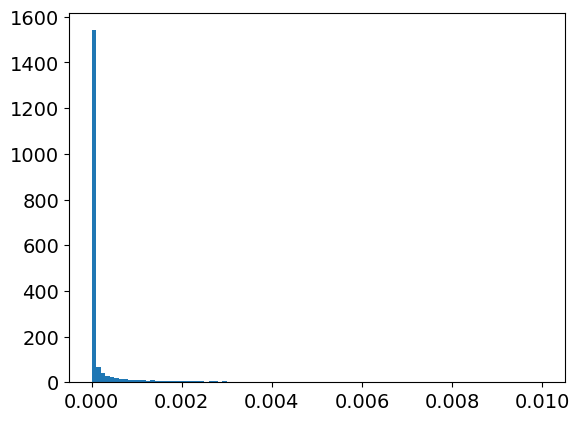

In [66]:
plt.hist(average_weights[2], bins = 100)